In [139]:
#Make a timeseries that is easy to take slices out. So you can investigate little sections in more detail.
#Try making a dict

import pandas as pd
import numpy as np
from datetime import datetime

column_names=["year","month","day","hour","ws"]
dtype={"year":int,"month":int,"day":int,"hour":int,"ws":float}

datafile='/home/sophie/projects/windspeed/data/61401BirMoghrein_allwinds.txt'

#specify the columns you want to group together. Can't include hour at this point as it is not in the right format. 
date_spec = {'date_time': [0,1,2]}

#when you use keep_dat_col it keeps them as objects, not as the dtype you read them in as.
wind = pd.read_csv(datafile, sep=" ", names=column_names, parse_dates=date_spec, keep_date_col=True, index_col=False ) 

#Dealing with hour - going from 600, 1200 etc to 6,12, 18
wind["hour"]=(wind["hour"]/100).astype(int)

#combining year, month, day that were parsed together into date_time with hour, which is now in the correct format.
wind['date_time'] = pd.to_datetime(wind.date_time) + wind.hour.astype('timedelta64[h]')


The aim here is to produce an array the same size as wind, but with two more columns with the mean and std for each month. 

In [140]:
#creates a group object, which you can then apply aggregate
grouped = wind.groupby(['year','month'])

#we only want ws in w. Here we get mean and std added on.
w = grouped['ws'].aggregate([np.mean,np.std])

print w['mean'][0:10]

year  month
1984  10       4.461757
      11       4.610763
      12       4.471414
      3        5.060840
      4        5.219944
      5        5.595610
      6        6.520606
      7        6.095756
      8        6.809480
      9        5.542466
Name: mean, dtype: float64


In [141]:

##########################################################################
#check that this is averaging in the way I think it is! By year, then month.
#extract just the values for 1984, month 10

#First need to change year,month, day into ints
wind[['year','month','day']]=wind[['year','month','day']].astype(int)

#Just needed brackets around each condition!
onemonth = wind[(wind['year']== 1984) & (wind['month'] == 3)]
print onemonth['ws'].mean()

5.06083952381


There results above prove that groupby() does what I want! However it is a shame that I can't do it using the datetime index column. 

In [142]:
#Need to extend the averaged values out into an array the same size as wind. I think transform is needed.
#From the documentation http://pandas.pydata.org/pandas-docs/stable/groupby.html#transformation 
#f = lambda x: x.fillna(x.mean())
#transformed = grouped.transform(f)

#####################
#This works!
f = lambda x: x.mean()
g = lambda x: x.std()

##At this stage transformed is a new object, index is not in any way related to our original wind df
transformed = grouped.transform(f)

print transformed.head()
print len(transformed)

         day  hour       ws
0  17.015873  12.0  5.06084
1  17.015873  12.0  5.06084
2  17.015873  12.0  5.06084
3  17.015873  12.0  5.06084
4  17.015873  12.0  5.06084
29372


In [164]:
#This also works like above but skips the step where you make grouped.
#This time I am continuing on to make std and add them both to original wind df
wind_mean = wind.groupby(['year','month']).transform(f)
wind_std = wind.groupby(['year','month']).transform(g)


In [170]:
#This line seems to do what the next two lines do together
wind['mean_ws'],wind['std_ws'] = wind_mean['ws'],wind_std['ws']

#A more lengthy way to do the above.
#wind['mean_ws'] = pd.Series(wind_mean['ws'], index = wind.index)
#wind['std_ws'] = pd.Series(wind_std['ws'], index = wind.index)

#This is exactly what I wanted.
print wind.head()

#this shows that the two extra columns have been added.
print wind.dtypes

            date_time  year  month  day  hour       ws  mean_ws    std_ws
0 1984-03-01 06:00:00  1984      3    1     6  3.54349  5.06084  2.280239
1 1984-03-01 12:00:00  1984      3    1    12  1.86284  5.06084  2.280239
2 1984-03-01 18:00:00  1984      3    1    18  1.01765  5.06084  2.280239
3 1984-03-02 06:00:00  1984      3    2     6  2.29602  5.06084  2.280239
4 1984-03-02 12:00:00  1984      3    2    12  4.95783  5.06084  2.280239
date_time    datetime64[ns]
year                  int64
month                 int64
day                   int64
hour                  int64
ws                  float64
mean_ws             float64
std_ws              float64
dtype: object


Now I have a dataframe which has two extra columns - mean_ws and std_ws. These are calculated monthly and that value is given to each of rows in the original dataframe. This allows for easy plotting of different frequency averaging on the timeseries.

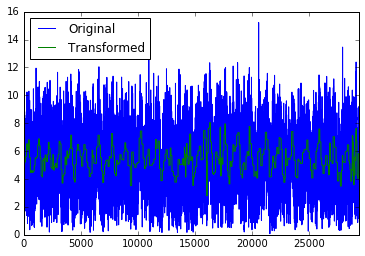

In [171]:
%matplotlib inline

import matplotlib.pyplot as plt

#compare the two. This allows you to quickly see the impact of different frequency averaging.
compare = pd.DataFrame({'Original':wind['ws'], 'Transformed':wind['mean_ws']})

compare.plot()


date_time    datetime64[ns]
year                  int64
month                 int64
day                   int64
hour                  int64
ws                  float64
mean_ws             float64
std_ws              float64
dtype: object


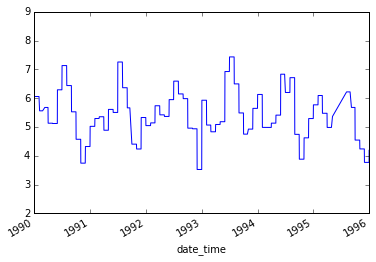

In [188]:
# Now I want to plot the mean and standard deviation for each month

wind = wind.set_index(wind['date_time'])#makes no difference to the key error below

wind['mean_ws'].plot(xlim=('1990','1996'))

#plt.errorbar(wind['mean_ws'],yerr=wind['std_ws'], linestyle="None", marker="None", color="green")

#plt.show()

print wind.dtypes